In [1]:
# Попробовать несколько датасетов
# Закодить новый алгоритм
# Добавить его в воркфлоу
# Подобрать хороши гипермараметры

In [1]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import neal
import greedy
import tabu
import matplotlib.pyplot as plt

import sys
from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../Data/Multidimensional Knapsack'))
from util import *

from IPython.display import display_html
from itertools import chain, cycle

import time

# Load data

In [77]:
data_folder = '../data/Multidimensional Knapsack/'
# Both Weish and WEING problems are just problems. There is no 
# difference between them, just more instances
# We have Weish[01-30] files in Weish folder
weish_files_no = 30
weish_file_paths = ['weish//Weish'+ str(i).zfill(2) +'.npz' for i in range(1, weish_files_no + 1)]
weish_loaded_files = [np.load(data_folder + i) for i in weish_file_paths]
# We have WEING[1-8] files in Weing folder
weing_files_no = 8
weing_file_paths = ['weing//WEING'+ str(i) +'.npz' for i in range(1, weing_files_no + 1)]
weing_loaded_files = [np.load(data_folder + i) for i in weing_file_paths]
loaded_files = weish_loaded_files + weing_loaded_files
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Custom Methods

In [80]:
def convert_1d_qubo_to_2d(qubo, n):
    if (len(qubo)!= (n) * ((n+1) * 0.5)   + 1):
        print('check that n is the correct size')
        return None, None
    constant = qubo[0]
    linear_terms = np.array(qubo[1:(n + 1)])
    no_of_quadratic_terms = len(qubo) - len(linear_terms) -1
    quadratic_terms = np.array(qubo[-no_of_quadratic_terms:])
    k = 0
    qubo_coeffs = []
    for i in range(n):
        coeffs = []
        for j in range(n):
            if(i == j):
                coeffs.append(linear_terms[i])
            elif(j>i):
                coeffs.append(quadratic_terms[k])
                k+=1
            else:
                coeffs.append(0)
        qubo_coeffs.append(coeffs)
    qubo_coeffs = np.array(qubo_coeffs)

    return qubo_coeffs, constant

In [81]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:left">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Prepare data

In [82]:
obj_qubos, obj_constants, con_qubos, con_constants = [], [], [], []

for i in range(len(qubo_sizes)):
    obj = convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])
    const = convert_1d_qubo_to_2d(constraints[i], qubo_sizes[i])
    obj_qubos.append(obj[0])
    obj_constants.append(obj[1])
    con_qubos.append(const[0])
    con_constants.append(const[1])

In [83]:
print('constant term and QUBO matrix representing the cost (unconstrained objective) function' )
print(obj_constants[0], obj_qubos[0])
print('constant term and QUBO matrix representing the constraint function' )
print(con_constants[0], con_qubos[0])

constant term and QUBO matrix representing the cost (unconstrained objective) function
0 [[360   0   0 ...   0   0   0]
 [  0  83   0 ...   0   0   0]
 [  0   0  59 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
constant term and QUBO matrix representing the constraint function
1298080 [[127183  19348  17556 ...   -752   -376   -188]
 [     0 272396  39720 ...   -688   -344   -172]
 [     0      0 324856 ...   -640   -320   -160]
 ...
 [     0      0      0 ...  -3376     16      8]
 [     0      0      0 ...      0  -1692      4]
 [     0      0      0 ...      0      0   -847]]


In [84]:
######## QUBO you need to solve ########
# TODO check if verma and lewis penalty is doing everything as expected
penalties = [util.verma_penalty(i) for i in obj_qubos]
print('penalties', penalties)
#QUBO matrix 
Qs = [-1*obj_qubo + penalty * con_qubo for obj_qubo, penalty, con_qubo in zip(obj_qubos, penalties, con_qubos)]
#constant term
cs = [-1*obj_constant+ penalty * con_constant for obj_constant, penalty, con_constant in zip(obj_constants, penalties, con_constants)]

penalties [892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 892, 30800, 30800, 30800, 30800, 30800, 30800, 107200, 107200]


In [85]:
#change QUBO matrix to the dwave format
newQs = [util.convert_QUBO_to_dwave_format(Q) for Q in Qs]
# Solve every QUBO 10 times with a different seed
# But remember to start with 1 as simulated annealing does not work with seed=0
repeats = 10

## Greedy

In [86]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Format {seed : [objective_energies, constraint_energies]}
greedy_runs = {}

# TODO using seeds is kind of pointless as we 
# TODO same budget as SA, keep seeds
for seed in range(1, repeats + 1):
    clear_output(wait=True)
    # Solve every QUBO
    greedy_objs = []
    greedy_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=1)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)
        
        # Even though we have multiplied the objective function by -1 to 
        # transfer it to minimisation problem when defining a QUBO,
        # we do not need to multiply it by -1 again as we are using the original 
        # objective function here.
        # So here we will have the original objective function value.
        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        # The constraint function before multiplying it by penalty coefficient
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        greedy_objs.append(obj)
        greedy_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    
    greedy_runs[seed] = (greedy_objs, greedy_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Simulated Annealing

In [87]:
# TODO use numreads instead of seed
#run solver
sampler = neal.SimulatedAnnealingSampler()

sa_runs = {}

for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    sa_objs = []
    sa_cons = []
    for problem_num in range(len(newQs)):
        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=10)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        sa_objs.append(obj)
        sa_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    sa_runs[seed] = (sa_objs, sa_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Tabu

In [88]:
#run solver
sampler = tabu.TabuSampler()

# Hyperparameters
timeout = 20 # default 20

tabu_runs = {}

# TODO numreads instead of seeds
for seed in range(1, repeats+1):
    clear_output(wait=True)
    # Solve every QUBO
    tabu_objs = []
    tabu_cons = []
    for problem_num in range(len(newQs)):

        response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout)

        #print("samples=" + str(list(response.samples())))
        #print("energies=" + str(list(response.data_vectors['energy'])) )

        solution = list(response.samples())[-1]

        y = np.array([int(solution[i]) for i in range(len(solution))])
        #print(y)

        obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
        con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
        tabu_objs.append(obj)
        tabu_cons.append(con)

        #print('The objective function value of x is ',obj )
        #print('The constraint function value of x is ',con )
    tabu_runs[seed] = (tabu_objs, tabu_cons)
    print(np.round(seed/repeats * 100, 2), '%')

100.0 %


## Record the results

In [89]:
greedy_results = []
sa_results = []
tabu_results = []

for i in range(1, repeats + 1):
    
    # 1: QUBO size, 2: penalty coeffficient, 3: objective function energy 
    # 4: constraint function energy (without taking into account penalty coefficient), 
    # 5: total QUBO energy (since we are transfering maximisation problem to minimisation,
    # we need to take the negative of objective function).
    # Energy should be negative if no constraints were broken as we will be the negative of objective
    # function and adding it to the constraint function.
    greedy_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : greedy_runs[i][0], 
                                 'Broken Constraints' : greedy_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(greedy_runs[i][0], greedy_runs[i][1], penalties)]})

    sa_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : sa_runs[i][0], 
                                 'Broken Constraints' : sa_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(sa_runs[i][0], sa_runs[i][1], penalties)]})

    tabu_results_local = pd.DataFrame({'Size' : qubo_sizes, 
                                 'Penalty' : penalties, 
                                 'Objective Function' : tabu_runs[i][0], 
                                 'Broken Constraints' : tabu_runs[i][1],
                                 'Energy (minimisation)' : [-list1+list2*penalty for list1, list2, penalty in zip(tabu_runs[i][0], tabu_runs[i][1], penalties)]})

    greedy_results.append(greedy_results_local)
    sa_results.append(sa_results_local)
    tabu_results.append(tabu_results_local)
    
# Display the first repetition table
rep = 9
display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,892,3191,3911,3485421
1,85,892,3245,11139,9932743
2,90,892,2733,291,256839
3,85,892,3219,2423,2158097
4,90,892,3128,4601,4100964
5,100,892,3601,1063,944595
6,100,892,3621,1686,1500291
7,100,892,4256,485,428364
8,100,892,3918,445,393022
9,110,892,4215,2692,2397049


## Analyse results

In [92]:
# Show total energies of all tries in all problems in a single df
energies_greedy = pd.DataFrame()
energies_sa = pd.DataFrame()
energies_tabu = pd.DataFrame()
for i in range(repeats):
    energies_greedy[f'Energy (minimisation) {i}'] = greedy_results[i]['Energy (minimisation)']
    energies_sa[f'Energy (minimisation) {i}'] = sa_results[i]['Energy (minimisation)']
    energies_tabu[f'Energy (minimisation) {i}'] = tabu_results[i]['Energy (minimisation)']

energies_greedy

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,429881,1841279,456563,854603,828662,905908,749842,10529825,831244,3485421
1,1699656,2181526,2811990,190381,6763932,201588,730313,2721128,230632,9932743
2,252813,2063500,817390,515816,260684,2737845,792493,3056733,1327915,256839
3,449405,1231662,7774245,1012084,432916,985005,948864,1072885,3752187,2158097
4,19551161,9535685,2751187,1808109,52219980,1877364,1883505,2650909,573929,4100964
5,472937,644878,933600,5930460,24006,1723876,424034,1012343,29778248,944595
6,2049498,5108263,595568,5722795,836084,271300,5686850,863675,5290259,1500291
7,3029831,882824,496313,15671199,32485,1724768,1910099,865163,26872501,428364
8,282743,18199028,614974,590180,645146,789131,434249,1048457,1220306,393022
9,445639,2061510,628517,7337706,3069236,12486592,3806304,10498377,1201285,2397049


In [94]:
# Show feasible solutions
feasible_full_greedy = pd.DataFrame()
feasible_full_sa = pd.DataFrame()
feasible_full_tabu = pd.DataFrame()
for i in range(repeats):
    feasible_full_greedy[f'Feasible {i}'] = greedy_results[i]['Broken Constraints'] == 0
    feasible_full_sa[f'Feasible {i}'] = sa_results[i]['Broken Constraints'] == 0
    feasible_full_tabu[f'Feasible {i}'] = tabu_results[i]['Broken Constraints'] == 0

feasible_full_tabu

,Feasible 0,Feasible 1,Feasible 2,Feasible 3,Feasible 4,Feasible 5,Feasible 6,Feasible 7,Feasible 8,Feasible 9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [95]:
# Calculate number of feasible solutions (in all runs)
feasible_greedy = pd.DataFrame({'Feasible' : feasible_full_greedy.sum(axis=1)})
feasible_sa = pd.DataFrame({'Feasible' : feasible_full_sa.sum(axis=1)})
feasible_tabu = pd.DataFrame({'Feasible' : feasible_full_tabu.sum(axis=1)})
# Calculate feasibility rate
feasible_greedy['Feasibility rate'] = feasible_greedy['Feasible'] / repeats
feasible_sa['Feasibility rate'] = feasible_sa['Feasible'] / repeats
feasible_tabu['Feasibility rate'] = feasible_tabu['Feasible'] / repeats
# Calculate mean energy
feasible_greedy['Mean energy'] = energies_greedy.mean(axis=1)
feasible_sa['Mean energy'] = energies_sa.mean(axis=1)
feasible_tabu['Mean energy'] = energies_tabu.mean(axis=1)
# Calculate energy standard deviation
feasible_greedy['SD energy'] = energies_greedy.std(axis=1)
feasible_sa['SD energy'] = energies_sa.std(axis=1)
feasible_tabu['SD energy'] = energies_tabu.std(axis=1)
# Calculate total row
feasible_greedy.loc['Total'] = feasible_greedy.sum()
feasible_sa.loc['Total'] = feasible_sa.sum()
feasible_tabu.loc['Total'] = feasible_tabu.sum()
# Calculate mean row
feasible_greedy.loc['Mean'] = feasible_greedy.mean()
feasible_sa.loc['Mean'] = feasible_sa.mean()
feasible_tabu.loc['Mean'] = feasible_tabu.mean()
# Calculate SD row
feasible_greedy.loc['SD'] = feasible_greedy.std()
feasible_sa.loc['SD'] = feasible_sa.std()
feasible_tabu.loc['SD'] = feasible_tabu.std()

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Mean energy,SD energy
0,0.000000,0.000000,2.091323e+06,3.101318e+06
1,0.000000,0.000000,2.746389e+06,3.207747e+06
2,0.000000,0.000000,1.208203e+06,1.055322e+06
3,0.000000,0.000000,1.981735e+06,2.257205e+06
4,0.000000,0.000000,9.695279e+06,1.599376e+07
5,0.000000,0.000000,4.188898e+06,9.147107e+06
6,0.000000,0.000000,2.792458e+06,2.345639e+06
7,0.000000,0.000000,5.191355e+06,8.919256e+06
8,0.000000,0.000000,2.421724e+06,5.551116e+06
9,0.000000,0.000000,4.393222e+06,4.254532e+06


# Run Length Distribution

## Greedy

In [96]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Solve QUBO a lot of times
problem_num = 25
seed = 0
response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=100000)

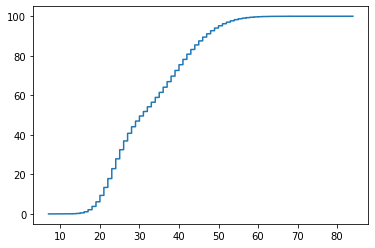

In [97]:
x = []
y = []

for steps, energy in response.data(fields=['num_steps', 'energy'], sorted_by='num_steps'):
    x.append(steps)
    y.append(energy)

# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))
    
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

## Tabu

In [99]:
#run solver
sampler = tabu.TabuSampler()

x = []
y = []

# Hyperparameters
timeout = 10 # default 20
problem_num = 25
# num restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
for seed in range(1, 1000):
    start = time.time()
    response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout, num_reads=1, num_restarts=1)
    end = time.time()
    x.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    y.append(energy)
    

In [100]:
# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))

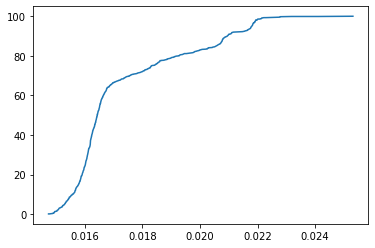

In [101]:
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

# new

In [ ]:
def verma_penalty(qubo_obj):
        weights = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        for i in range(len(qubo_obj)):
            weights[k]= qubo_obj[i][i]
            weights[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights[k]+= qubo_obj[i][j]
                    else:
                        weights[k+1]-=qubo_obj[i][j]
            k = k+2
        return max(weights)

In [61]:
def new_penalty(qubo_obj, con_obj):
        weights_obj = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        weights_con = np.zeros(shape = (len(con_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(qubo_obj)):
            weights_obj[k]= qubo_obj[i][i]
            weights_obj[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights_obj[k]+= qubo_obj[i][j]
                    else:
                        weights_obj[k+1]-=qubo_obj[i][j]
            k = k+2
            
        for i in range(len(con_obj)):
            print(i)
            weights_con[k]= con_obj[i][i]
            weights_con[k+1]= -con_obj[i][i]
            for j in range(len(con_obj)):
                if(i!=j):
                    if(con_obj[i][j] > 0):
                        weights_con[k]+= con_obj[i][j]
                    else:
                        weights_con[k+1]-=con_obj[i][j]
            k = k+2
        return max(weights)/min(weights_con)

In [62]:
new_penalties = [new_penalty(i, j) for (i, j) in zip(obj_qubos, con_qubos)]

0


IndexError: index 170 is out of bounds for axis 0 with size 170